# 캡스톤 디자인(Capstone Design)

Subject: 전이 학습을 이용한 Smart 칼로리 저울

전이 학습을 통해 학습된 모델을 이용하여 음식을 인식

어떤 음식인지 구별 후, 실제 음식의 무게 측정

실제 음식의 무게를 1g당 칼로리값을 대입후 총 칼로리 도출

In [ ]:
#한글 폰트 설정하기
import matplotlib.pyplot as plt
from matplotlib import rc  
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

#사용한 모듈
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import time
import os

In [2]:
#gpu 사용을 위한 구문
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation),랜덤 수평 뒤집기
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    # 정규화(normalization), scaling(scale 조절), centering(중심 지정)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 2268
테스트 데이터셋 크기: 223
클래스: ['갈비구이', '갈치구이', '계란찜', '김밥', '김치찌개', '된장찌개', '물회', '배추김치', '삼계탕', '새우튀김', '소세지볶음', '수정과', '식혜', '약과', '육회', '족발', '찜닭', '한과', '해물찜', '후라이드치킨']


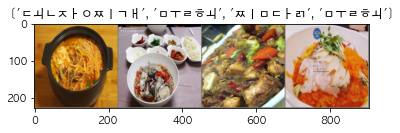

In [5]:
#학습데이터가 잘 들어 갔는지 확인하기 위해 실행
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [6]:
#모델 초기화  
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features

# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 20개로 설정하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 20)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/jhs/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [7]:
#epochs수를 많이 하지 않아도 충분한 정확도가 나오기에 30만 진행

num_epochs = 30
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        #gradient를 0으로 초기화, torch는 미분값들이 누적되는 특징
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#0 Loss: 1.6341 Acc: 51.0141% Time: 205.9974s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#1 Loss: 0.8526 Acc: 73.7213% Time: 420.3857s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#2 Loss: 0.7134 Acc: 78.0423% Time: 638.0133s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#3 Loss: 0.5061 Acc: 85.5379% Time: 852.2820s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#4 Loss: 0.4115 Acc: 88.5802% Time: 1079.8144s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#5 Loss: 0.3991 Acc: 88.3598% Time: 1305.2817s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#6 Loss: 0.3701 Acc: 89.0212% Time: 1529.2736s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#7 Loss: 0.2918 Acc: 91.7548% Time: 1754.5981s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#8 Loss: 0.2881 Acc: 91.3139% Time: 1983.4004s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#9 Loss: 0.2172 Acc: 94.2240% Time: 2209.2089s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#10 Loss: 0.1786 Acc: 94.4444% Time: 2435.7631s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#11 Loss: 0.2064 Acc: 94.0035% Time: 2642.4248s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#12 Loss: 0.1510 Acc: 95.6349% Time: 2852.9740s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#13 Loss: 0.1469 Acc: 95.6349% Time: 3064.0875s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#14 Loss: 0.1563 Acc: 95.5467% Time: 3275.4638s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#15 Loss: 0.0944 Acc: 97.3545% Time: 3484.3517s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#16 Loss: 0.1130 Acc: 97.0018% Time: 3695.3625s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#17 Loss: 0.1035 Acc: 96.9136% Time: 3905.8702s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#18 Loss: 0.1081 Acc: 96.6931% Time: 4117.2225s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#19 Loss: 0.0706 Acc: 97.8836% Time: 4329.5327s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#20 Loss: 0.0830 Acc: 97.5309% Time: 4541.7159s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#21 Loss: 0.0996 Acc: 97.4868% Time: 4757.2157s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#22 Loss: 0.0938 Acc: 97.1340% Time: 5626.6955s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#23 Loss: 0.0543 Acc: 98.5891% Time: 5840.0036s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#24 Loss: 0.0804 Acc: 97.6190% Time: 6054.4840s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#25 Loss: 0.0714 Acc: 97.8836% Time: 6268.9622s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#26 Loss: 0.0737 Acc: 97.7072% Time: 6482.7464s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#27 Loss: 0.0707 Acc: 97.7072% Time: 6701.2950s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#28 Loss: 0.0594 Acc: 98.2363% Time: 6921.4536s


/Users/jhs/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#29 Loss: 0.0433 Acc: 99.0300% Time: 7149.2193s


[예측 결과: 후라이드치킨] (실제 정답: 후라이드치킨)


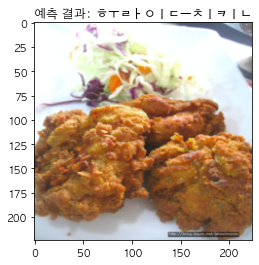

[예측 결과: 물회] (실제 정답: 물회)


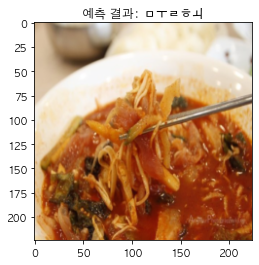

[예측 결과: 새우튀김] (실제 정답: 새우튀김)


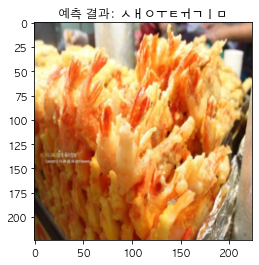

[예측 결과: 약과] (실제 정답: 약과)


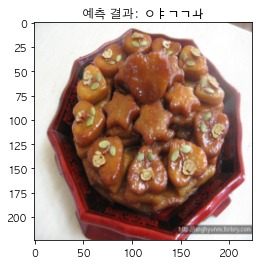

[예측 결과: 소세지볶음] (실제 정답: 소세지볶음)


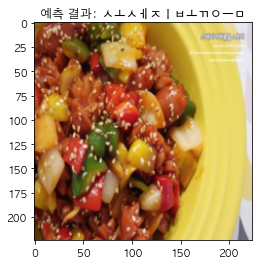

[예측 결과: 배추김치] (실제 정답: 배추김치)


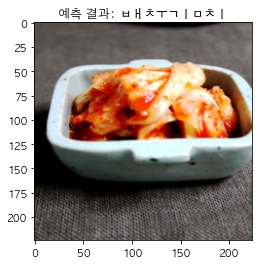

[예측 결과: 김밥] (실제 정답: 김밥)


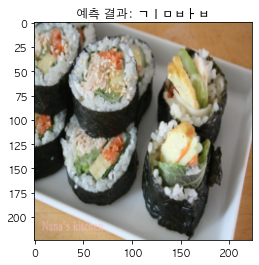

[예측 결과: 새우튀김] (실제 정답: 새우튀김)


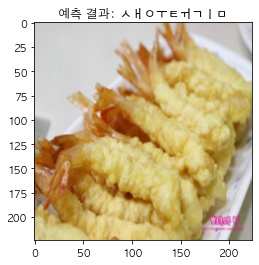

[예측 결과: 한과] (실제 정답: 갈치구이)


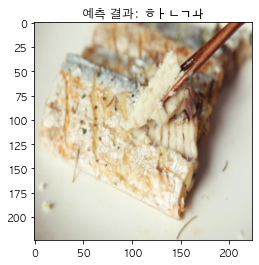

[예측 결과: 김치찌개] (실제 정답: 김치찌개)


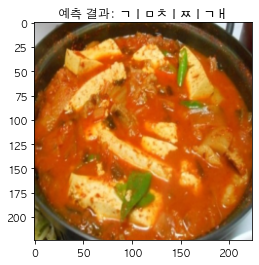

[예측 결과: 김치찌개] (실제 정답: 김치찌개)


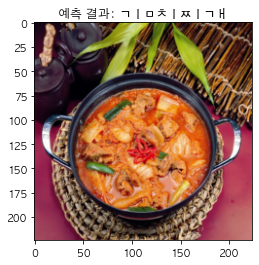

[예측 결과: 된장찌개] (실제 정답: 된장찌개)


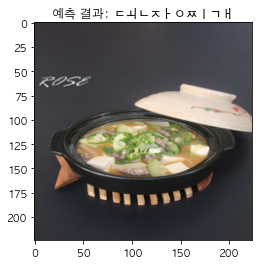

[예측 결과: 갈비구이] (실제 정답: 갈비구이)


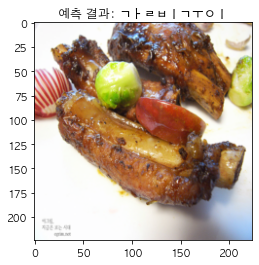

[예측 결과: 후라이드치킨] (실제 정답: 후라이드치킨)


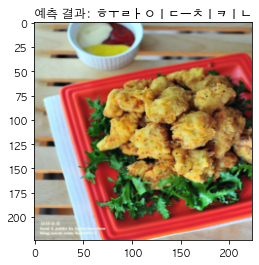

[예측 결과: 계란찜] (실제 정답: 계란찜)


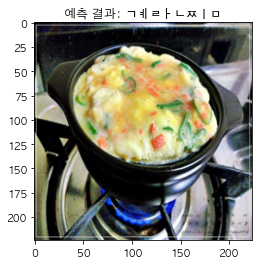

[예측 결과: 계란찜] (실제 정답: 계란찜)


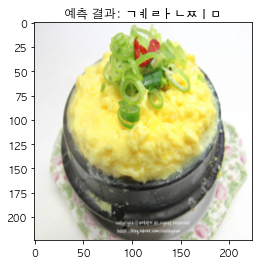

[예측 결과: 약과] (실제 정답: 약과)


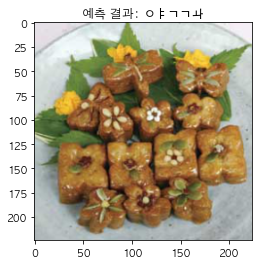

[예측 결과: 새우튀김] (실제 정답: 새우튀김)


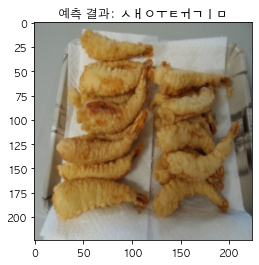

[예측 결과: 해물찜] (실제 정답: 해물찜)


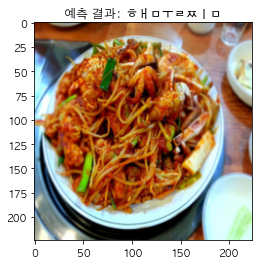

[예측 결과: 약과] (실제 정답: 약과)


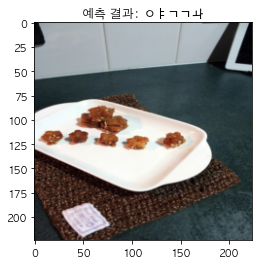

[예측 결과: 한과] (실제 정답: 한과)


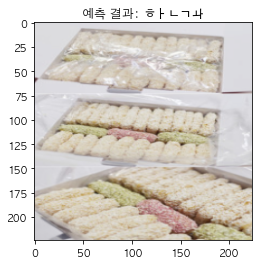

[예측 결과: 소세지볶음] (실제 정답: 소세지볶음)


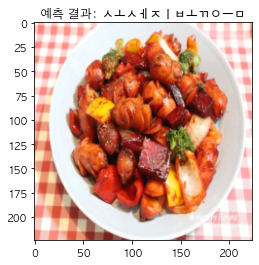

[예측 결과: 육회] (실제 정답: 육회)


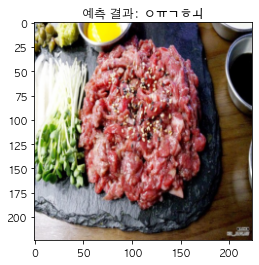

[예측 결과: 족발] (실제 정답: 족발)


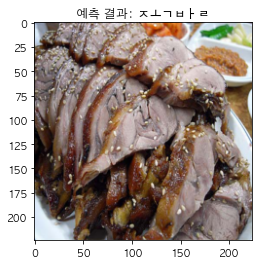

[예측 결과: 물회] (실제 정답: 물회)


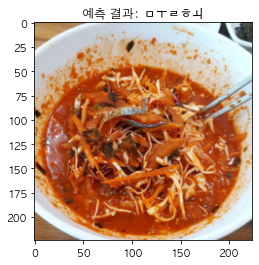

[예측 결과: 후라이드치킨] (실제 정답: 후라이드치킨)


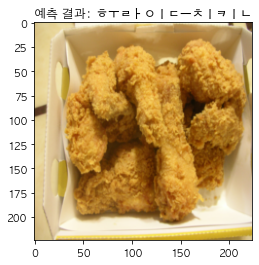

[예측 결과: 물회] (실제 정답: 물회)


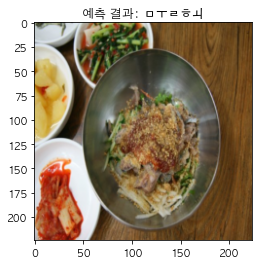

[예측 결과: 갈치구이] (실제 정답: 갈치구이)


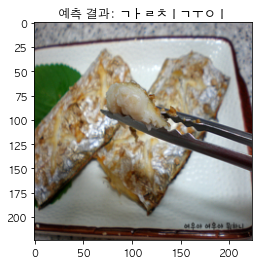

[예측 결과: 삼계탕] (실제 정답: 삼계탕)


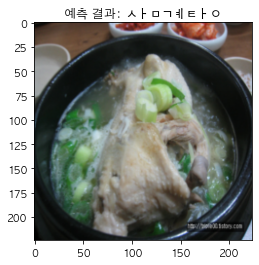

[예측 결과: 수정과] (실제 정답: 수정과)


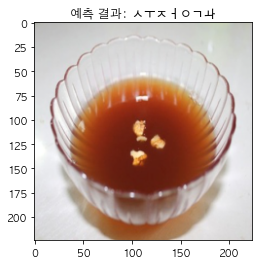

[예측 결과: 갈치구이] (실제 정답: 갈치구이)


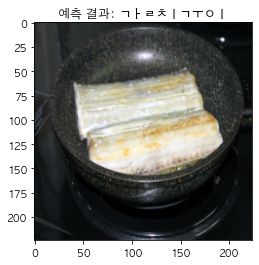

[예측 결과: 새우튀김] (실제 정답: 새우튀김)


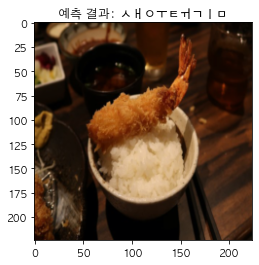

[예측 결과: 물회] (실제 정답: 물회)


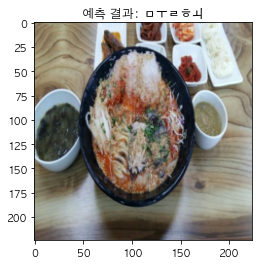

[예측 결과: 계란찜] (실제 정답: 계란찜)


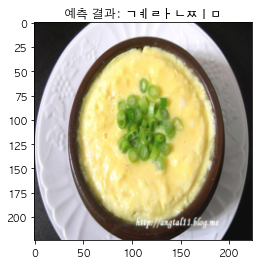

[예측 결과: 소세지볶음] (실제 정답: 소세지볶음)


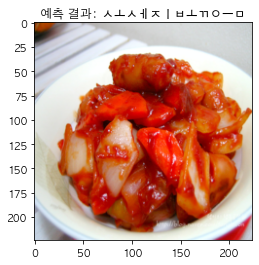

[예측 결과: 족발] (실제 정답: 족발)


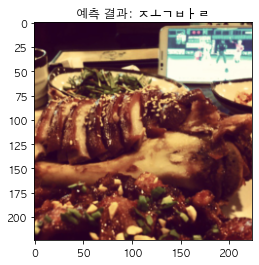

[예측 결과: 새우튀김] (실제 정답: 새우튀김)


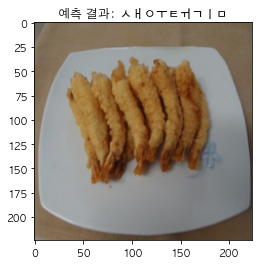

[예측 결과: 물회] (실제 정답: 물회)


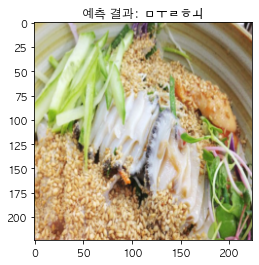

[예측 결과: 한과] (실제 정답: 한과)


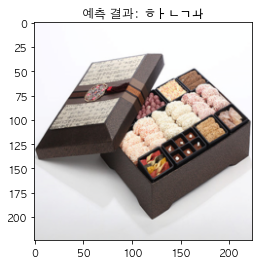

[예측 결과: 배추김치] (실제 정답: 배추김치)


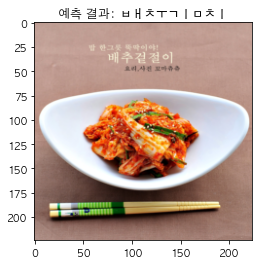

[예측 결과: 된장찌개] (실제 정답: 수정과)


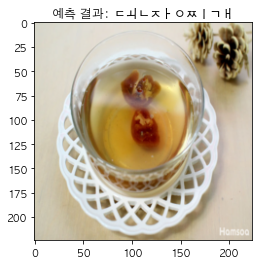

[예측 결과: 육회] (실제 정답: 육회)


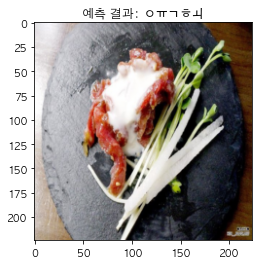

[예측 결과: 갈치구이] (실제 정답: 갈치구이)


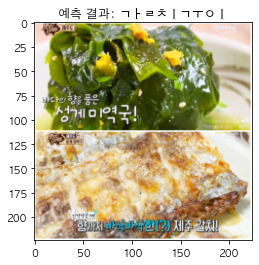

[예측 결과: 약과] (실제 정답: 약과)


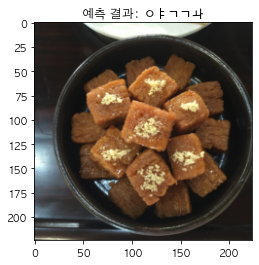

[예측 결과: 해물찜] (실제 정답: 해물찜)


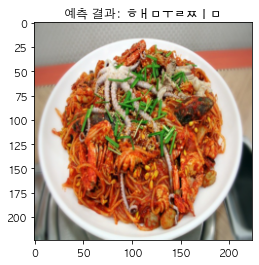

[예측 결과: 계란찜] (실제 정답: 계란찜)


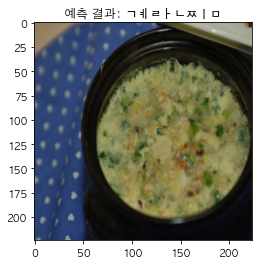

[예측 결과: 삼계탕] (실제 정답: 삼계탕)


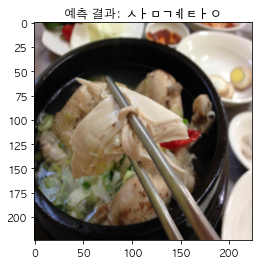

[예측 결과: 수정과] (실제 정답: 수정과)


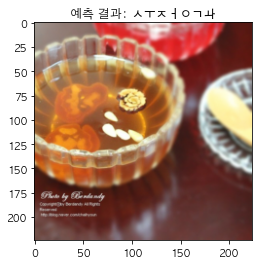

[예측 결과: 갈비구이] (실제 정답: 갈비구이)


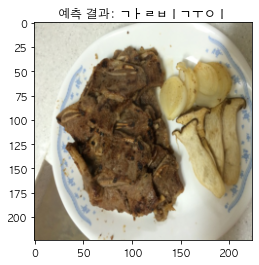

[예측 결과: 갈비구이] (실제 정답: 갈비구이)


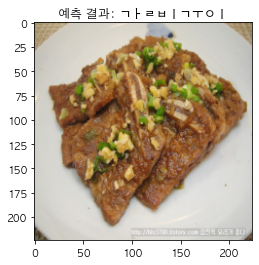

[예측 결과: 김치찌개] (실제 정답: 김치찌개)


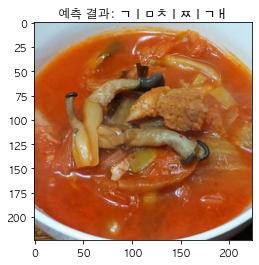

[예측 결과: 물회] (실제 정답: 갈비구이)


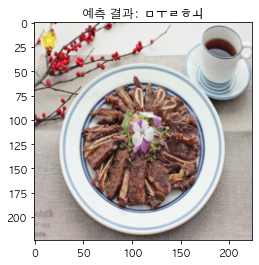

[예측 결과: 된장찌개] (실제 정답: 된장찌개)


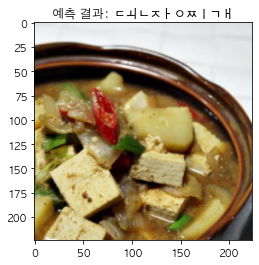

[예측 결과: 해물찜] (실제 정답: 해물찜)


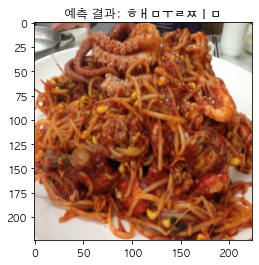

[예측 결과: 족발] (실제 정답: 족발)


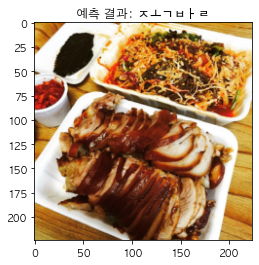

[예측 결과: 육회] (실제 정답: 배추김치)


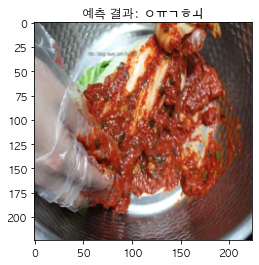

[Test Phase] Loss: 0.3326 Acc: 90.1345% Time: 29.7412s


In [239]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

In [83]:
# Index에 맞는 음식 1g당 kcal값 대응 코드
calories_array=[ 391/200, 101/70, 220/150, 485/300, 121/200, 171/200, 208/300, 24/50, 454/500, 277/100, 236/100, 
               85/238, 90/150, 167/40, 137/100, 688/200, 385/200, 425/100, 269/200, 221/85]


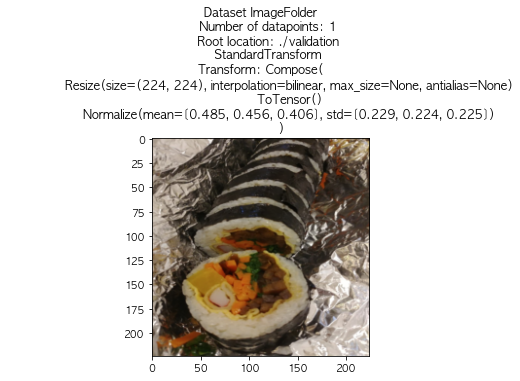

In [241]:
import matplotlib.pyplot as plt
%matplotlib inline
validation_dataset = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transforms_test)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=2)
out = torchvision.utils.make_grid(inputs)
iterator = iter(validation_dataset)
inputs, classes = next(iterator)
imshow(out, validation_dataset)

(예측 결과: 김밥)
김밥의 무게:357g
김밥의 1g당 칼로리:1.955kcal
김밥의 총 칼로리:577.15kcal


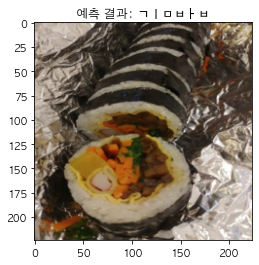

In [246]:
calories_array=[ 391/200, 101/70, 220/150, 485/300, 121/200, 171/200, 208/300, 24/50, 454/500, 277/100, 236/100, 
               85/238, 90/150, 167/40, 137/100, 688/200, 385/200, 425/100, 269/200, 221/85]
#저울 대체 랜덤함수
import random
gram= random.randint(100,400)

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in validation_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        kcal=gram*calories_array[preds[0]]
        
        print(f'(예측 결과: {class_names[preds[0]]})') ,
        print("{}의 무게:{}g" .format(class_names[preds[0]],gram))
        
        print("{}의 1g당 칼로리:{}kcal".format(class_names[preds[0]],calories_array[0]))
        print("{}의 총 칼로리:{}kcal".format(class_names[preds[0]] , kcal))

        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])